# Gaussian Mixture Models
by Marc Deisenroth

In this notebook, we will look at density modeling with Gaussian mixture models (GMMs).
In Gaussian mixture models, we describe the density of the data as
$$
p(\boldsymbol x) = \sum_{k=1}^K \pi_k \mathcal{N}(\boldsymbol x|\boldsymbol \mu_k, \boldsymbol \Sigma_k)\,,\quad \pi_k \geq 0\,,\quad \sum_{k=1}^K\pi_k = 1
$$

The goal of this notebook is to get a better understanding of GMMs and to write some code for training GMMs using the EM algorithm. We provide a code skeleton and mark the bits and pieces that you need to implement yourself.

In [1]:
# imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.linalg as la
import matplotlib.cm as cm
from matplotlib import rc
import time
from IPython import display

%matplotlib inline

np.random.seed(42)

### Define a GMM from which we generate data
Set up the true GMM from which we will generate data.

In [68]:
# Choose a GMM with 3 components

# means
m = np.zeros((3,2))
m[0] = np.array([1.2, 0.4])
m[1] = np.array([-4.4, 1.0])
m[2] = np.array([4.1, -0.3])

# covariances
S = np.zeros((3,2,2))
S[0] = np.array([[0.8, -0.4], [-0.4, 1.0]])
S[1] = np.array([[1.2, -0.8], [-0.8, 1.0]])
S[2] = np.array([[1.2, 0.6], [0.6, 3.0]])

# mixture weights
w = np.array([0.3, 0.2, 0.5])

Generate some data

In [98]:
N_split = 200 # number of data points per mixture component
N = N_split*3 # total number of data points
x = []
y = []
for k in range(3):
    x_tmp, y_tmp = np.random.multivariate_normal(m[k], S[k], N_split).T 
    x = np.hstack([x, x_tmp])
    y = np.hstack([y, y_tmp])

data = np.vstack([x, y])

Visualization of the dataset

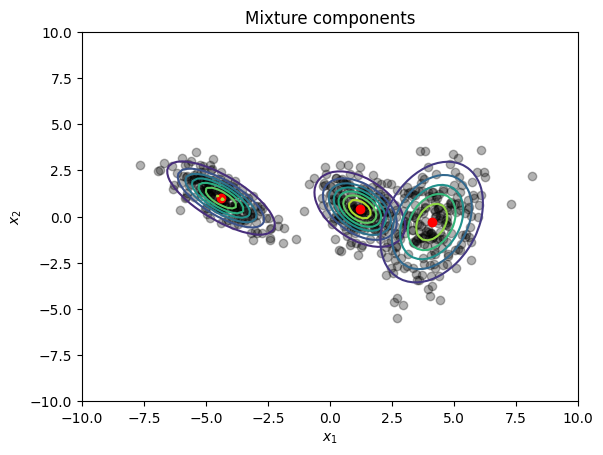

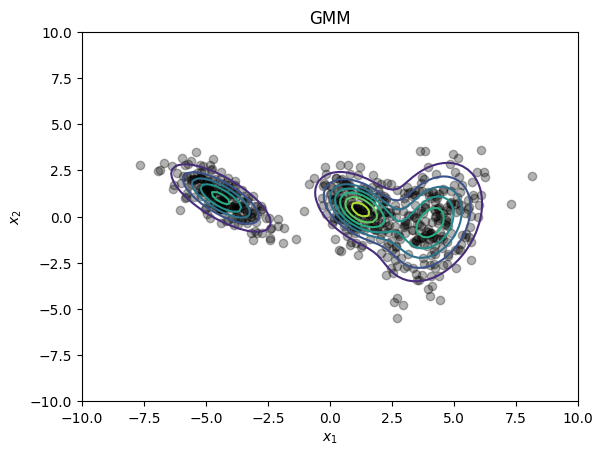

In [70]:
X, Y = np.meshgrid(np.linspace(-10,10,100), np.linspace(-10,10,100))
pos = np.dstack((X, Y))

mvn = multivariate_normal(m[0,:].ravel(), S[0,:,:])
xx = mvn.pdf(pos)

# plot the dataset
plt.figure()
plt.title("Mixture components")
plt.plot(x, y, 'ko', alpha=0.3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

# plot the individual components of the GMM
plt.plot(m[:,0], m[:,1], 'or')

for k in range(3):
    mvn = multivariate_normal(m[k,:].ravel(), S[k,:,:])
    xx = mvn.pdf(pos)
    plt.contour(X, Y, xx,  alpha = 1.0, zorder=10)
     
# plot the GMM 
plt.figure()
plt.title("GMM")
plt.plot(x, y, 'ko', alpha=0.3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

# build the GMM
gmm = 0
for k in range(3):
    mix_comp = multivariate_normal(m[k,:].ravel(), S[k,:,:])
    gmm += w[k]*mix_comp.pdf(pos)
    
plt.contour(X, Y, gmm,  alpha = 1.0, zorder=10);

## Train the GMM via EM
### Initialize the parameters for EM

In [97]:
K = 3 # number of clusters

means = np.zeros((K,2))
covs = np.zeros((K,2,2))
for k in range(K):
    means[k] = np.random.normal(size=(2,))
    covs[k] = np.eye(2)

weights = np.ones((K,1))/K
print("Initial mean vectors (one per row):\n" + str(means))
print("Initial cov matrices (one per row):\n" + str(covs))
print("Initial weight vectors (one per row):\n" + str(weights))

Initial mean vectors (one per row):
[[-0.33912228  0.37006112]
 [-0.12373268  0.45780561]
 [-0.49693203 -0.18256897]]
Initial cov matrices (one per row):
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
Initial weight vectors (one per row):
[[0.33333333]
 [0.33333333]
 [0.33333333]]


Given the model
$$
p(\boldsymbol x|\mu_k, \Sigma_k, \pi_k) = \sum_{k=1}^K \pi_k \mathcal{N}(\boldsymbol x|\boldsymbol \mu_k, \boldsymbol \Sigma_k)\,,\quad \pi_k \geq 0\,,\quad \sum_{k=1}^K\pi_k = 1
$$

We we compute the negative log-likelihood as follows:

$$
\log p(x|\mu, \Sigma, \pi) = \log \prod_{n=1}^N p(x_n|\mu, \Sigma, \pi) = \log \prod_{n=1}^N \sum_{k=1}^K \pi_k \mathcal{N}(\boldsymbol x|\boldsymbol \mu_k, \boldsymbol \Sigma_k) =
$$

$$
= \sum_{n=1}^N \log \sum_{k=1}^K \pi_k \mathcal{N}(\boldsymbol x|\boldsymbol \mu_k, \boldsymbol \Sigma_k)
$$

4800.533703473436


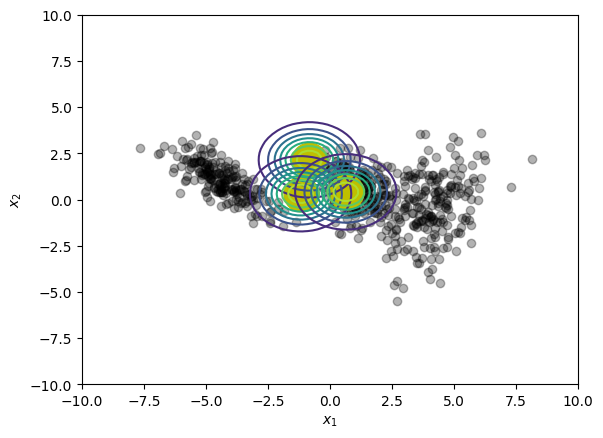

In [77]:
#EDIT THIS FUNCTION
NLL = [] # log-likelihood of the GMM
gmm_nll = 0
for k in range(K):  
    rv = multivariate_normal(means[k,:], covs[k,:,:])
    gmm_nll += weights[k]*rv.pdf(data.T)
NLL = -np.sum(np.log(gmm_nll))
print(NLL)

plt.figure()
plt.plot(x, y, 'ko', alpha=0.3)
plt.plot(means[:,0], means[:,1], 'oy', markersize=25)

for k in range(K):
    rv = multivariate_normal(means[k,:], covs[k,:,:])
    plt.contour(X, Y, rv.pdf(pos), alpha = 1.0, zorder=10)
    
plt.xlabel("$x_1$");
plt.ylabel("$x_2$");

First, we define the responsibilities (which are updated in the E-step), given the model parameters $\pi_k, \boldsymbol\mu_k, \boldsymbol\Sigma_k$ as
$$
r_{nk} := \frac{\pi_k\mathcal N(\boldsymbol
          x_n|\boldsymbol\mu_k,\boldsymbol\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(\boldsymbol
          x_n|\boldsymbol \mu_j,\boldsymbol\Sigma_j)} 
          $$

Given the responsibilities we just defined, we can update the model parameters in the M-step as follows:
$$
\begin{align*}
\boldsymbol\mu_k^\text{new} &= \frac{1}{N_k}\sum_{n = 1}^Nr_{nk}\boldsymbol x_n\,,\\
   \boldsymbol\Sigma_k^\text{new}&= \frac{1}{N_k}\sum_{n=1}^Nr_{nk}(\boldsymbol x_n-\boldsymbol\mu_k)(\boldsymbol x_n-\boldsymbol\mu_k)^\top\,,\\
   \pi_k^\text{new} &= \frac{N_k}{N}
\end{align*}
$$
where 
$$
N_k := \sum_{n=1}^N r_{nk}
$$

### EM Algorithm

In [127]:
#EDIT THIS FUNCTION
r = np.zeros((K,N)) # will store the responsibilities
covs = S

#for em_iter in range(100):    
for em_iter in range(1):    
    means_old = means.copy()
    weights_old = weights.copy()
    covs_old = covs.copy()

    total_responsability = 0
    for k in range(K):
        rv = multivariate_normal(means_old[k,:], covs_old[k,:,:])
        total_responsability += weights_old[k]*rv.pdf(data.T)
    
    # E-step: update responsibilities
    r = [weights_old[k]*multivariate_normal.pdf(mean=means_old[k,:], cov=covs_old[k,:,:], x=data.T)/total_responsability for k in range(K)]
    # K x N
    r = np.array(r)
    
    # # M-step
    # N_k = np.sum(r, axis=1)

    # for k in range(K): 
    #     # update the means
    #     means[k] = 0 #<-- REPLACE THIS LINE
        
    #     # update the covariances
    #     covs[k] = 0  #<-- REPLACE THIS LINE
        
    # # weights
    # weights = np.zeros((K,)) #<-- REPLACE THIS LINE
    
    # # log-likelihood
    # NLL += [10] #<-- REPLACE THIS LINE
    
    # plt.figure() 
    # plt.plot(x, y, 'ko', alpha=0.3)
    # plt.plot(means[:,0], means[:,1], 'oy', markersize=25)
    # for k in range(K):
    #     rv = multivariate_normal(means[k,:], covs[k])
    #     plt.contour(X, Y, rv.pdf(pos), alpha = 1.0, zorder=10)
        
    # plt.xlabel("$x_1$")
    # plt.ylabel("$x_2$")
    # plt.text(x=3.5, y=8, s="EM iteration "+str(em_iter+1))
    
    # if la.norm(NLL[em_iter+1]-NLL[em_iter]) < 1e-6:
    #     print("Converged after iteration ", em_iter+1)
    #     break
   
# # plot final the mixture model
# plt.figure() 
# gmm = 0
# for k in range(3):
#     mix_comp = multivariate_normal(means[k,:].ravel(), covs[k,:,:])
#     gmm += weights[k]*mix_comp.pdf(pos)

# plt.plot(x, y, 'ko', alpha=0.3)
# plt.contour(X, Y, gmm,  alpha = 1.0, zorder=10)    
# plt.xlim([-8,8]);
# plt.ylim([-6,6]);

IndexError: list index out of range

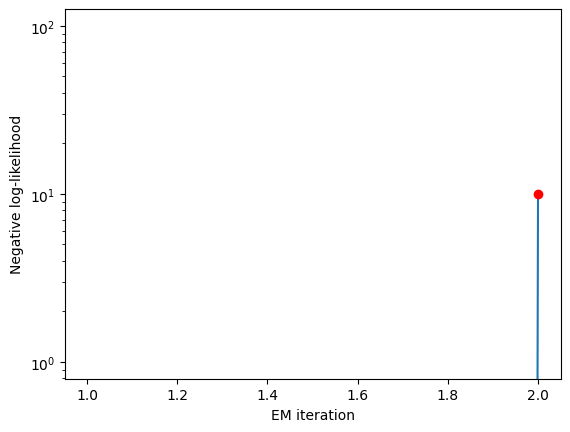

In [14]:
plt.figure()
plt.semilogy(np.linspace(1,len(NLL), len(NLL)), NLL)
plt.xlabel("EM iteration");
plt.ylabel("Negative log-likelihood");

idx = [0, 1, 9, em_iter+1]

for i in idx:
    plt.plot(i+1, NLL[i], 'or')